"Run all" on this notebook to skip all analysis and generate all plots from the paper

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import richardsplot
from astropy.cosmology import FlatLambdaCDM
from astropy.stats import sigma_clip
from scipy.stats import norm


Bad key "text.kerning_factor" on line 4 in
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def figsze(hscale, 
            vscale=0.618034,
            fig_width_pt = 504.0):
    """Get the fig_width_pt by inserting the textwidth into LaTeX document.
    hscale is fraction of text width you want.
    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width*vscale                   # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.5,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 16,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 16,
    "legend.fontsize": 12,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 16,              # Font size of numbers 
    "ytick.labelsize": 16,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    'xtick.major.width':1, 
    'xtick.minor.width':1, 
    'ytick.major.width':1, 
    'ytick.minor.width':1, 
    'xtick.major.size':10,             # size of tickmarks in points
    'xtick.minor.size':5, 
    'ytick.major.size':10, 
    'ytick.minor.size':5,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

In [3]:
#Equations

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def radluminosity(nu1, nu2, S, alpha, z):
    #calculate luminosity at nu1 based on flux at nu2
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    L = ((4*np.pi*DL**2*(S*1e-23*1e-6)) / ((1+z)**(1+alpha))) * (nu1/nu2)**alpha * 1e-7
    return np.log10(L)

def fluxdensity(nu1, nu2, L, alpha, z):
    #calculate flux density at nu2 based on luminosity at nu1
    L = 10.**L
    DL = 3.086e24*cosmo.luminosity_distance(z).value
    S = L * (nu2/nu1)**alpha * (((1+z)**(1+alpha))/(4*np.pi*DL**2)) * 1e36
    return S #return flux density in microJy

def SFR_L14(L14):
    #Yun+2001 SFR relation based on 1.4GHz luminosity
    return 5.9e-22 * (10**L14)

def SFR_Mi(Mi):
    #Absolute magnitude SFR relation from Harris+2016
    return -29*Mi**2 - 1625*Mi - 22505

def SFR_eqw(E):
    #Equation 8 of Harris+2016 - compute SFR given EQW measurements
    return 4205*E**(-.5) - 328

In [18]:
radluminosity(1.4, 3., 3*7.5, -0.7, 1.65)

23.712595513096886

In [4]:
figs = pd.read_csv("SpringFinalFigs_moreParams.csv")
z = figs[["redshift_1"]].values.flatten()
det = figs[['detection']].values.astype("int").flatten()
Sp3 = figs[['peak_flux']].values.flatten()
S3 = figs[['int_flux']].values.flatten()
L3 = radluminosity(3., 3., S3, -0.7, z)
ew_civ = figs[['ICA_CIV_EQW']].values.flatten()
voff_civ = figs[['ICA_CIV_BLUESHIFT']].values.flatten()
F = figs[['FIRST']].values.astype("int").flatten()
CIVdist = figs[["RM_DIST_SCALE"]].values.flatten()

D = det+F


col = ["red", "blue", "orange"]

figs

,col1,name,follow_up,RMS,peak_flux,PFerr,int_flux,IFerr,S/N,redshift_1,...,LOGBH_CIV_VP06_ERR,LOGBH,LOGBH_ERR,LOGEDD_RATIO,SPECIAL_INTEREST_FLAG,Separation,ICA_CIV_BLUESHIFT,ICA_CIV_EQW,RM_DIST_UNSCALE,RM_DIST_SCALE
0,233,SDSSJ001342.45-002412.6,0,9.8,163.0,17.0,219.0,37.0,16.632653,1.650561,...,0.129601,9.336939,0.075891,-0.424730,0,0.000422,1488.886594,101.160257,1728.413701,3.486256
1,293,SDSSJ014023.83+141151.7,0,25.0,516.0,27.0,516.0,27.0,20.640000,1.650361,...,0.086887,9.606281,0.057232,-1.192428,0,0.002490,172.315874,95.079534,414.691980,2.589969
2,1270,SDSSJ014658.21-091505.2,0,10.0,30.0,NaN,30.0,NaN,NaN,1.650855,...,0.134377,9.510254,0.167256,-1.125770,0,0.003016,406.588017,97.289514,646.782974,2.704445
3,1281,SDSSJ015720.27-093809.1,0,14.3,42.9,NaN,42.9,NaN,NaN,1.650784,...,0.099762,8.959515,0.123747,-0.621876,0,0.003151,557.606423,122.740901,796.239578,2.635625
4,7944,SDSSJ081656.84+492438.1,1,8.7,26.1,NaN,26.1,NaN,NaN,1.650785,...,0.083127,8.727050,0.389167,-0.354559,0,0.010092,1250.742184,102.881571,1490.190560,3.289717
5,4892,SDSSJ082334.60+213917.5,1,10.5,31.5,NaN,31.5,NaN,NaN,1.651524,...,0.053638,8.983139,0.128000,-0.178485,0,0.009575,2546.015437,84.683592,2785.856718,4.374773
6,3648,SDSSJ082423.61+260656.3,1,8.6,25.8,NaN,25.8,NaN,NaN,1.650132,...,0.070588,8.805320,0.086349,-0.388599,0,0.008588,1465.652993,81.944644,1705.604287,3.530793
7,1902,SDSSJ082928.79+401608.4,1,9.9,29.7,NaN,29.7,NaN,NaN,1.650650,...,0.055991,8.849676,0.081097,-0.444108,0,0.011610,606.009758,127.268874,844.447795,2.635675
8,6463,SDSSJ090502.96+154553.0,0,20.0,60.0,NaN,60.0,NaN,NaN,1.650998,...,0.061590,9.120722,0.069841,-0.769660,0,0.018700,209.102409,114.691454,448.943684,2.483334
9,4951,SDSSJ092933.99+300240.8,0,10.0,83.2,11.0,83.2,11.0,8.320000,1.651654,...,0.072540,9.604903,0.023351,-1.009672,0,0.001287,416.268684,151.515720,653.167559,2.207581


# 1. Distributions of targets

The following figure plots the measured 3 GHz total flux densities from our sample.  The top axis shows the corresponding luminosity distribution assuming a uniform redshift $z=1.65$

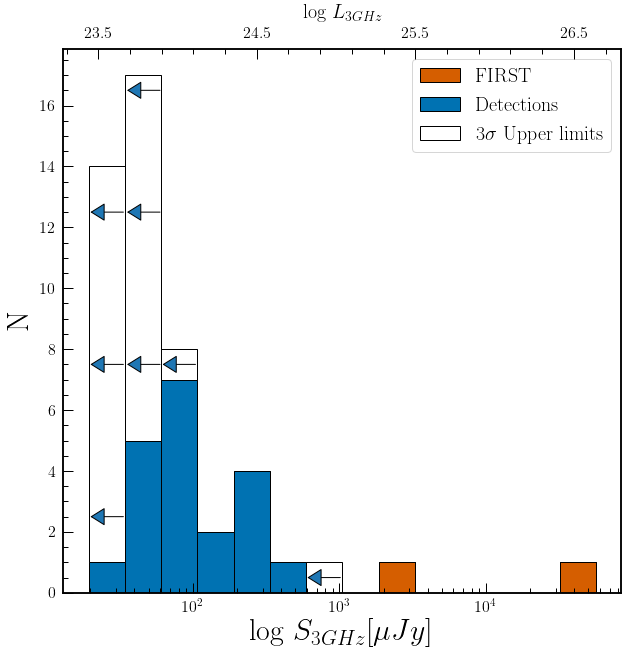

In [123]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

Lbins = np.linspace(min(L3), max(L3), 15)
Sbins = np.logspace(np.log10(min(S3)), np.log10(max(S3)), 15)


ax1.hist([S3[D==2], S3[D==1], S3[D==0]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Sbins, label=["FIRST", "Detections", "3$\sigma$ Upper limits"])


#Upper limit symbols
ax1.annotate('', xy=(10**1.54, 2.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 12.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**1.79, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 12.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 16.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**2.032, 7.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**3.02, 0.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))

#ax1.set_xscale("log")
ax1.set_xlabel("log $S_{3GHz}[\\mu Jy$]", fontsize=30)
ax1.set_ylabel("N", fontsize=30)
ax1.legend(loc="best", prop={"size": 20})
ax1.set_xscale("log")

#Manually add luminosity axis
ax2 = ax1.twiny()
ax2.set_xlim(23.28,26.8)
ax2.set_xticks([23.5, 24.5, 25.5, 26.5])
ax2.set_xlabel("log $L_{3GHz}$", fontsize=20)
plt.savefig("PaperPlots/flux_distribution_wlum.pdf")
plt.show()

^I added the secondary luminosity axis manually since making it a function of the flux x-axis was getting really annoying (IDK why, maybe since it's on a log scale?).  In any case, it's still accurate

----

# 2. CIV Space

In [6]:
#Load in data from RM sample
df2 = pd.read_csv('RM_CIV_Ordering/SDSSRMMedianCIVParams_wCIVDist.csv')
control_eqw = df2[["Median_CIV_EQW"]].values.flatten()
control_voff = df2[["Median_CIV_Blueshift"]].values.flatten()

#Unscaled CIV params from original file
Miz2 = figs[['MI_Z2']].values.flatten()
vla_eqw = figs[['ICA_CIV_EQW']].values.flatten()
vla_voff = figs[['ICA_CIV_BLUESHIFT']].values.flatten()

L14 = radluminosity(1.4, 3., S3, -0.7, z)

#Skip analysis to make main plot (this is all scaled data)
bestfit = np.load("RM_CIV_Ordering/CIV_PlotArrays/RM_CIV_bestFitLine_scale.npy")
control = np.load("RM_CIV_Ordering/CIV_PlotArrays/RM_CIVParams_scale.npy")
vla_civ = np.load("RM_CIV_Ordering/CIV_PlotArrays/VLA_CIVParams_scale.npy")
vlaXY = np.load("RM_CIV_Ordering/CIV_PlotArrays/VLA_CIV_fitXYCoords_scale.npy")

In [7]:
#Star formation rates from Harris/Yun
SFR_Mag = SFR_Mi(Miz2)
SFR_eq = SFR_eqw(ew_civ)
avgSFR = (SFR_Mag+SFR_eq)/2.
SFRL14 = SFR_L14(L14)

#The standard size scaling for these plots -
#Determination of this scaling happened in Trevor's version of "CIV_plot_GTR_fixed.ipynb"
#sent to GTR and AEK through the e-mail thread "VLA Paper" on 9/3/2020 at 5:05 PM

A = -490. #lower asymptote
K = 2500. #upper asymptote
B = 3.3 #growth rate
nu = 1. #affects where the max growth occurs
Q = 5. #related to intitial condition

logistic_harris = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR)))))**(1/nu)) for i in np.log10(avgSFR)])
logistic_yun = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(np.log10(avgSFR)))))**(1/nu)) for i in np.log10(SFRL14)])

#For the ratio plot the scaling is different
ratio = logistic_yun/logistic_harris

A = -380. #lower asymptote
K = 2000. #upper asymptote
B = .2 #growth rate
nu = 1. #affects where the max growth occurs
Q = 5. #related to intitial condition

logistic_ratio = np.array([A + (K-A)/((1+Q*np.e**(-B*(i-min(ratio))))**(1/nu)) for i in ratio])

## 2a) Same size, project points onto best fit line

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


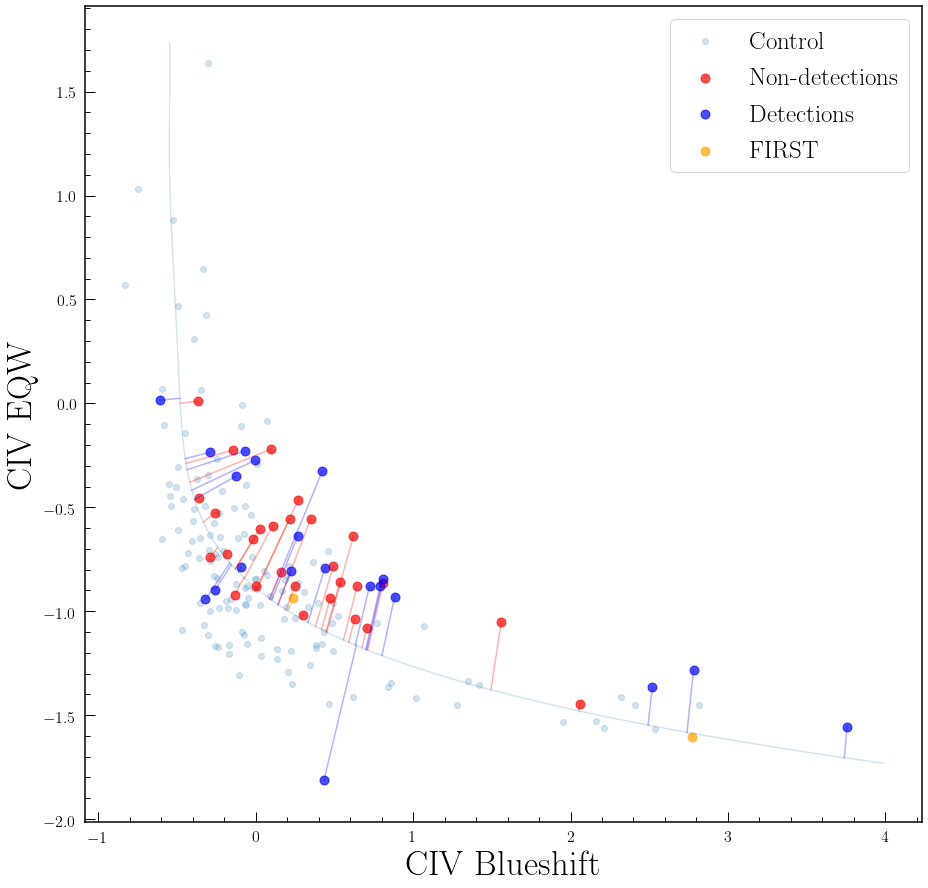

In [8]:
plt.figure(figsize=(15,15))

plt.plot(bestfit[:,0], bestfit[:,1], alpha=0.2)
plt.scatter(control[:,0], control[:,1], alpha=0.2, label="Control")


plt.scatter(vla_civ[:,0][D==0], vla_civ[:,1][D==0], s=80, color="red", alpha=0.7, label="Non-detections")
plt.scatter(vla_civ[:,0][D==1], vla_civ[:,1][D==1], s=80, color="blue", alpha=0.7, label="Detections")
plt.scatter(vla_civ[:,0][D==2], vla_civ[:,1][D==2], s=80, color="orange", alpha=0.7, label="FIRST")


for i in range(len(vla_civ)):
    plt.plot([vla_civ[i,0], vlaXY[i,0]], [vla_civ[i,1], vlaXY[i,1]], color=col[int(D[i])], alpha=0.3)
    


plt.xlabel("CIV Blueshift", fontsize=35)
plt.ylabel("CIV EQW", fontsize=35)
plt.legend(loc="best", prop={'size': 25})
plt.show()

## 2b) Unscaled data; scale the point sizes on the average SFR predicted from the optical luminosity / EQW relations from Harris+2016

In [53]:
#Use Yun+2001 to invert these SFRs to L1.4GHz
L14_eqw = 1.7e21*SFR_eqw(vla_eqw)
L14_Mi = 1.7e21*SFR_Mi(Miz2)
L14_gtr = 10.**logGTR
bins1 = np.logspace(np.log10(min(min(L14_eqw[L14_eqw>0.]), min(L14_Mi[L14_Mi>0.]))), np.log10(max(L14_gtr)), 35)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


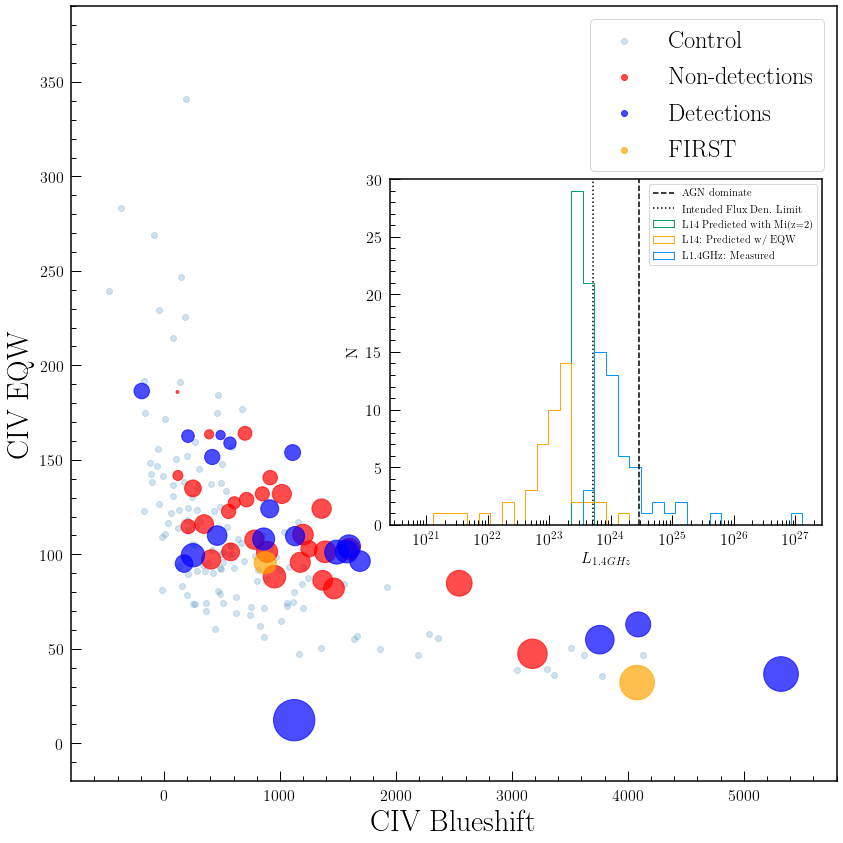

In [89]:
fig, ax1 = plt.subplots(figsize=(12,12))

ax1.scatter(control_voff, control_eqw, alpha=0.2, label="Control")

ax1.scatter(voff_civ[D==0], ew_civ[D==0], s=logistic_harris[D==0], color="red", alpha=0.7)
ax1.scatter(voff_civ[D==1], ew_civ[D==1], s=logistic_harris[D==1], color="blue", alpha=0.7)
ax1.scatter(voff_civ[D==2], ew_civ[D==2], s=logistic_harris[D==2], color="orange", alpha=0.7)

#Faux points so they're the same size in the legend
ax1.scatter(5000, 5000, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, color="orange", alpha=0.7, label="FIRST")

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.463, 0.38, 0.5, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.hist([L14_gtr, L14_eqw, L14_Mi], histtype="step", bins=bins1, color=["#0099ff", "#ffa500", "#009e73"],
          label=["L1.4GHz: Measured", "L14: Predicted w/ EQW", "L14 Predicted with Mi(z=2)"])
ax2.plot([10**24.45,10**24.45],[0,38],"--k",label="AGN dominate")
ax2.plot([10**23.71,10**23.71],[0,38],":k",label="Intended Flux Den. Limit")
ax2.set_ylim([0,30])
ax2.set_xscale("log")
ax2.set_xlabel("$L_{1.4GHz}$")
ax2.set_ylabel("N")
ax2.legend(loc="upper right", prop={"size":10.5})

ax1.set_xlabel("CIV Blueshift", fontsize=30)
ax1.set_ylabel("CIV EQW", fontsize=30)
ax1.set_xlim(-800,5800)
ax1.set_ylim(-20,390)
ax1.legend(loc="best", prop={'size': 24.5})
plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_sizeHarris_SFRinset.pdf")
plt.show()

## 2c) Unscaled data; scale the point sizes on the SFR predicted from the Yun radio luminosity relation

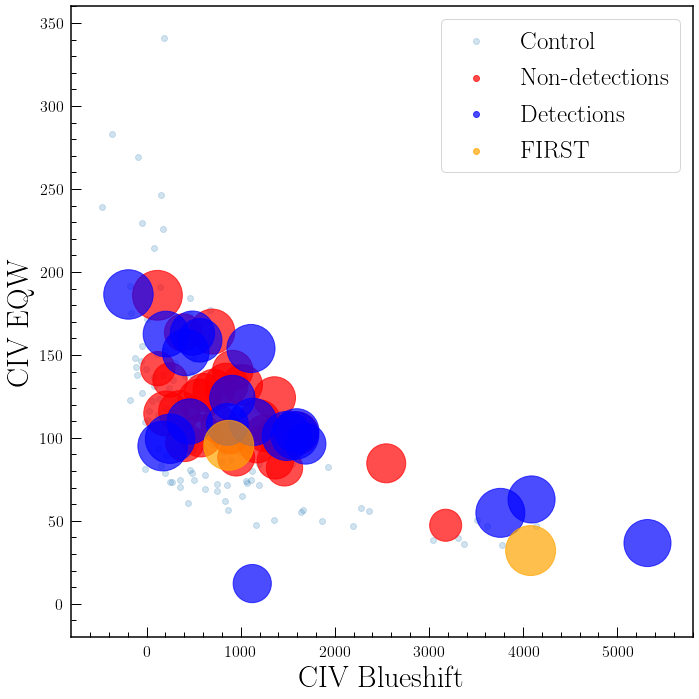

In [120]:
plt.figure(figsize=(10,10))

plt.scatter(control_voff, control_eqw, alpha=0.2, label="Control")

plt.scatter(voff_civ[D==0], ew_civ[D==0], s=logistic_yun[D==0], color="red", alpha=0.7)
plt.scatter(voff_civ[D==1], ew_civ[D==1], s=logistic_yun[D==1], color="blue", alpha=0.7)
plt.scatter(voff_civ[D==2], ew_civ[D==2], s=logistic_yun[D==2], color="orange", alpha=0.7)

#Faux points so they're the same size in the legend
plt.scatter(5000, 5000, color="red", alpha=0.7, label="Non-detections")
plt.scatter(5000, 5000, color="blue", alpha=0.7, label="Detections")
plt.scatter(5000, 5000, color="orange", alpha=0.7, label="FIRST")

plt.xlabel("CIV Blueshift", fontsize=30)
plt.ylabel("CIV EQW", fontsize=30)
plt.xlim(-800,5800)
plt.ylim(-20,360)
plt.legend(loc="best", prop={'size': 25})
plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_sizeYun.pdf")
plt.show()

## 2d) Now scale the sizes of points based on the ratio between the Harris and Yun relations; thus bigger points represent more excess radio emission than that predicted based on star formation from Harris

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


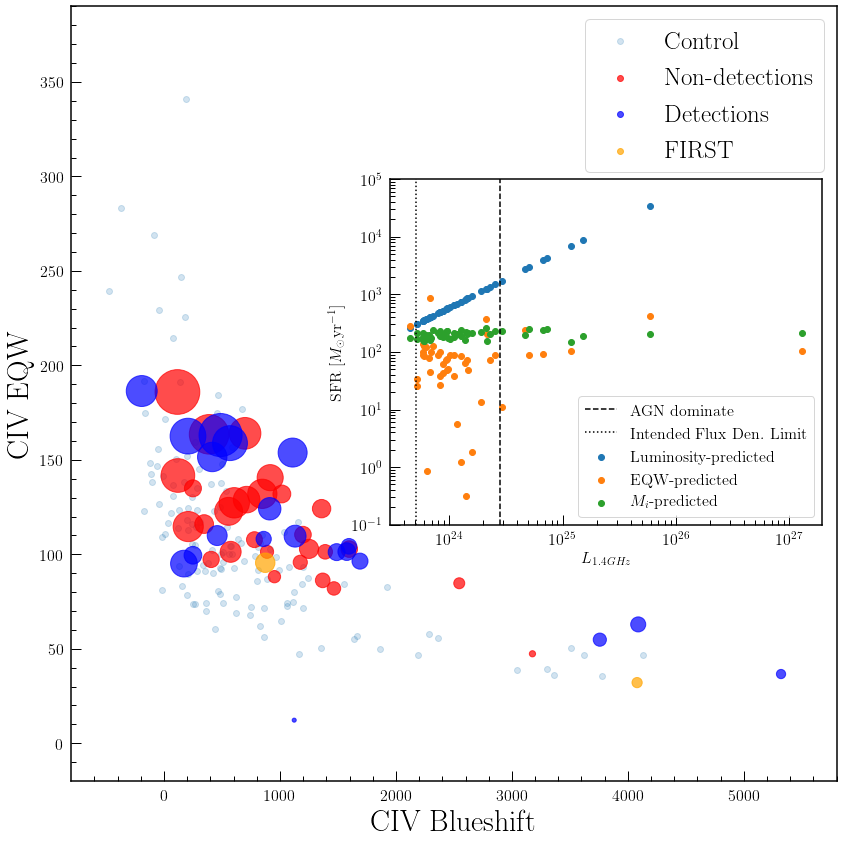

In [117]:
fig, ax1 = plt.subplots(figsize=(12,12))

ax1.scatter(control_voff, control_eqw, alpha=0.2, label="Control")

ax1.scatter(voff_civ[D==0], ew_civ[D==0], s=logistic_ratio[D==0], color="red", alpha=0.7)
ax1.scatter(voff_civ[D==1], ew_civ[D==1], s=logistic_ratio[D==1], color="blue", alpha=0.7)
ax1.scatter(voff_civ[D==2], ew_civ[D==2], s=logistic_ratio[D==2], color="orange", alpha=0.7)

#Faux points so they're the same size in the legend
ax1.scatter(5000, 5000, color="red", alpha=0.7, label="Non-detections")
ax1.scatter(5000, 5000, color="blue", alpha=0.7, label="Detections")
ax1.scatter(5000, 5000, color="orange", alpha=0.7, label="FIRST")

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.463, 0.38, 0.5, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.scatter(L14_gtr, SFR_L14(logGTR), label="Luminosity-predicted")
ax2.scatter(L14_gtr, SFR_eqw(vla_eqw), label="EQW-predicted")
ax2.scatter(L14_gtr, SFR_Mi(Miz2), label="$M_{i}$-predicted")
ax2.plot([10**24.45,10**24.45],[10**-1,10**5],"--k",label="AGN dominate")
ax2.plot([10**23.71,10**23.71],[10**-1,10**5],":k",label="Intended Flux Den. Limit")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylim(0.1, 10**5)
ax2.set_xlabel("$L_{1.4GHz}$")
ax2.set_ylabel("SFR [$M_{\odot} \mathrm{ yr}^{-1}$]")
ax2.legend(loc="best", prop={"size":16})

ax1.set_xlabel("CIV Blueshift", fontsize=30)
ax1.set_ylabel("CIV EQW", fontsize=30)
ax1.set_xlim(-800,5800)
ax1.set_ylim(-20,390)
ax1.legend(loc="best", prop={'size': 25})
plt.tight_layout()
plt.savefig("PaperPlots/CIVPlot_sizeRatio_SFRwlinesInset.pdf")
plt.show()

---

# 3. Forced Photometry

In [12]:
z_nvss = pd.read_csv("forced_photometry.csv")[["REDSHIFT"]].values.flatten()
fnvss = 1000.*(pd.read_csv("forced_photometry.csv")[["Flux Density (Jy/b)"]].values.flatten()) #values in Jy - want mJy
fnvss_clip = sigma_clip(fnvss,sigma_lower=3,sigma_upper=2.5,maxiters=10,masked=False)

logGTR = radluminosity(1.4, 3., S3, -0.7, z)

## 3a) Histogram of all NVSS peak flux densities measured at the optical location of all 8653 color-selected QSOs from our parent sample with the scaled up PDF overplotted (the PDF fit is only performed on the clipped data

Fit Results:
Mean   = 0.0905 mJy/b
Median = 0.0900 mJy/b
Std    = 0.4867 mJy/b


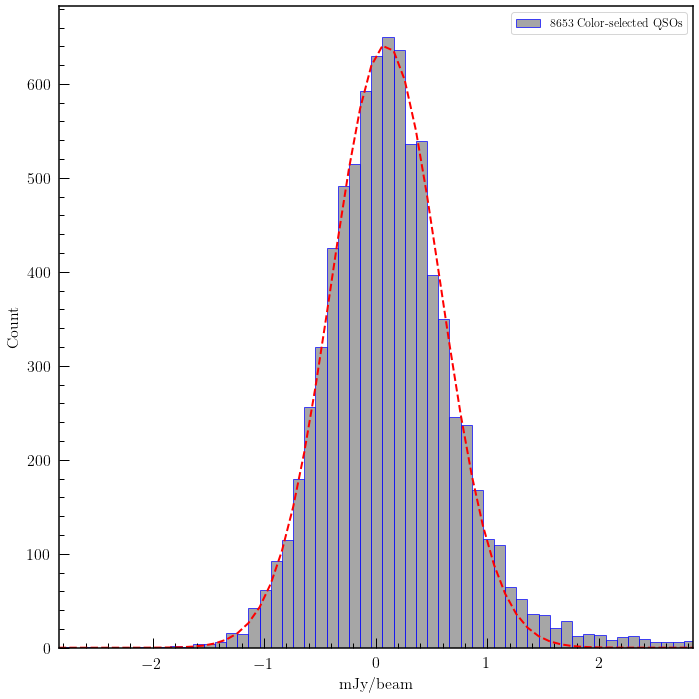

In [119]:
#Now do with clipped data
pf = 1e-3*S3 #convert GTR flux from µJy to mJy

# best fit of (clipped) data
# This gives the true median and sigma
(mu, sigma) = norm.fit(fnvss_clip)
median = np.median(fnvss_clip)

#Use the bins covering the full distribution
bins=np.arange(min(fnvss), max(fnvss), .1)

fig,ax = plt.subplots(1,1,figsize=(10,10))

#Plot fnvss histogram
plt.hist(fnvss,bins=bins,color='grey',edgecolor='b',alpha=0.7,label="8653 Color-selected QSOs")

#PDF of the clipped distribution
y = norm.pdf(bins, mu, sigma)
y_true = (y*len(fnvss_clip)*0.1) #get rid of normalization - 0.1 is bin width
plt.plot(bins, y_true, 'r--', linewidth=2)

plt.xlim(min(fnvss), abs(min(fnvss)))
plt.xlabel("mJy/beam")
plt.ylabel("Count")
plt.legend(loc="best")

print("Fit Results:")
print("Mean   = %.4f mJy/b" % (mu))
print("Median = %.4f mJy/b" % (median))
print("Std    = %.4f mJy/b" % (sigma))

plt.tight_layout()
plt.savefig("PaperPlots/nvssForcedphotometry_unscaled.pdf")
plt.show()

## 3b) GTR version: convert clipped positive flux densities to luminosity and illustrate some characteristic points on the distribution

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


1498


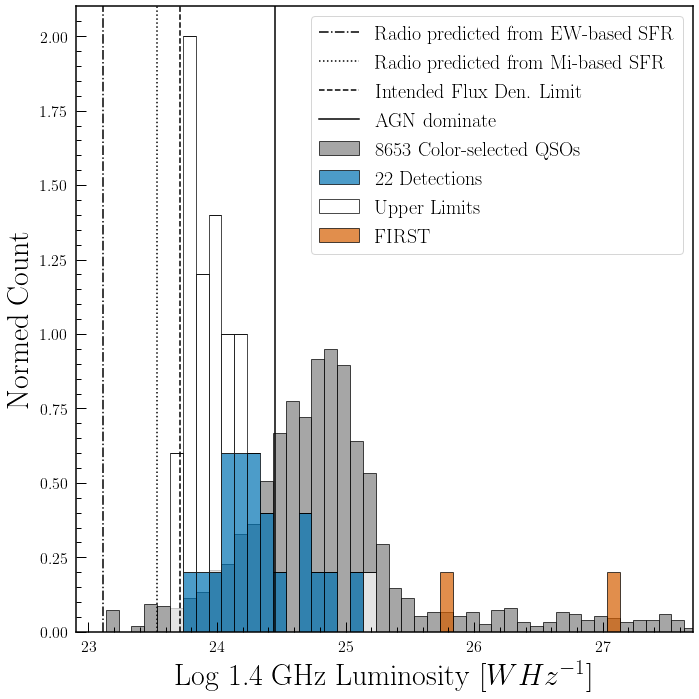

In [118]:
#GTR version, just compare to positive detections and z<1.75
#Don't really need the gaussian fit.

Lnvss = radluminosity(1.4, 1.4, 1000.*fnvss[(fnvss>0.)&(z_nvss<1.75)], -0.7, z_nvss[(fnvss>0.)&(z_nvss<1.75)])
Lnvssbins=np.arange(min(Lnvss), max(Lnvss), .1)
print(len(Lnvss))

fig,ax = plt.subplots(1,1,figsize=(10,10))

plt.hist(Lnvss, color="grey", edgecolor="k", bins=Lnvssbins, density=True, alpha=0.7, label="8653 Color-selected QSOs")

#Plot GTR data
plt.hist([logGTR[D==1], logGTR[D==0], logGTR[D==2]], histtype="barstacked", color=["#0072b2", "w", "#d55e00"], 
          alpha=0.7, edgecolor="k", density=True, bins=Lnvssbins, label=["22 Detections", "Upper Limits", "FIRST"])

#plt.annotate(s="$\mu$=24.81", xy=(25.6,1.3), size=45, color="red")
#plt.annotate(s="$\sigma$=0.54", xy=(25.6,1.1), size=45, color="red")

plt.plot([23.11,23.11],[0,38],"-.k",label="Radio predicted from EW-based SFR")
plt.plot([23.535,23.535],[0,38],":k",label="Radio predicted from Mi-based SFR")
plt.plot([23.71,23.71],[0,38],"--k",label="Intended Flux Den. Limit")
plt.plot([24.45,24.45],[0,38],"-k",label="AGN dominate")


plt.xlim(22.9, 27.7)
plt.ylim(0,2.1)
plt.xlabel("Log 1.4 GHz Luminosity [$W Hz^{-1}$]", fontsize=30)
plt.ylabel("Normed Count", fontsize=30)
plt.legend(loc="best", prop={"size":20})
plt.tight_layout()
plt.savefig("PaperPlots/nvssForcedPhotometry_GTRoverplotted_wlines.pdf")
plt.show()

---

# 4. Tying in optical data

We define $R$ as being the ratio between the measured radio flux density (3 GHz) and that measured in the optical (2500 Å):

$$ R = \frac{S_\mathrm{3GHz}}{S_{2500Å}} $$

In [137]:
#Eq 4 from QLF paper Richards+2006; subtract 7 to convert erg/s to Watts
d = 3.08e19 # 10pc in cm
logL2500 = -0.4 * (Miz2 + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.

R = (10.**L3)/(10.**logL2500)
logR = np.log10(R)

In [291]:
shen = pd.read_csv("PGv2_DR7_data/grdr7_Shen2011_targ_uni.csv")
#Optical data
z_hiz0 = shen[["REDSHIFT"]].values.flatten()
z_hiz = shen[["REDSHIFT"]].values.flatten()[(z_hiz0<1.75)]
Miz2_hiz = shen[["MI_Z2"]].values.flatten()[(z_hiz0<1.75)]
L2500_hiz = -0.4 * (Miz2_hiz + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.
#Radio data derived from forced photometry
#AGNmask=0.5: above AGN-dom, below jet-dom
#AGNmask=1.0: above jet-dom
AGNmask = shen[["AGNmask_fp_trevor"]].values.flatten()[(z_hiz0<1.75)]
L14_hiz = shen[["L14_fp_trevor"]].values.flatten()[(z_hiz0<1.75)]

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [293]:
kell = pd.read_csv("Kellermann_MIZ2.csv")
z_kell    = kell[["REDSHIFT"]].values.flatten()
Miz2_kell = kell[["MI_Z2"]].values.flatten()
L2500_kell= -0.4 * (Miz2_kell + 48.6 + 2.5*np.log10(1.+2.)) + np.log10(4.*np.pi*d**2.) - 7.
S6_kell   = kell[["S(6)_t"]].values.flatten()
L14_kell   = radluminosity(1.4, 6., S6_kell, -0.7, z_kell)

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


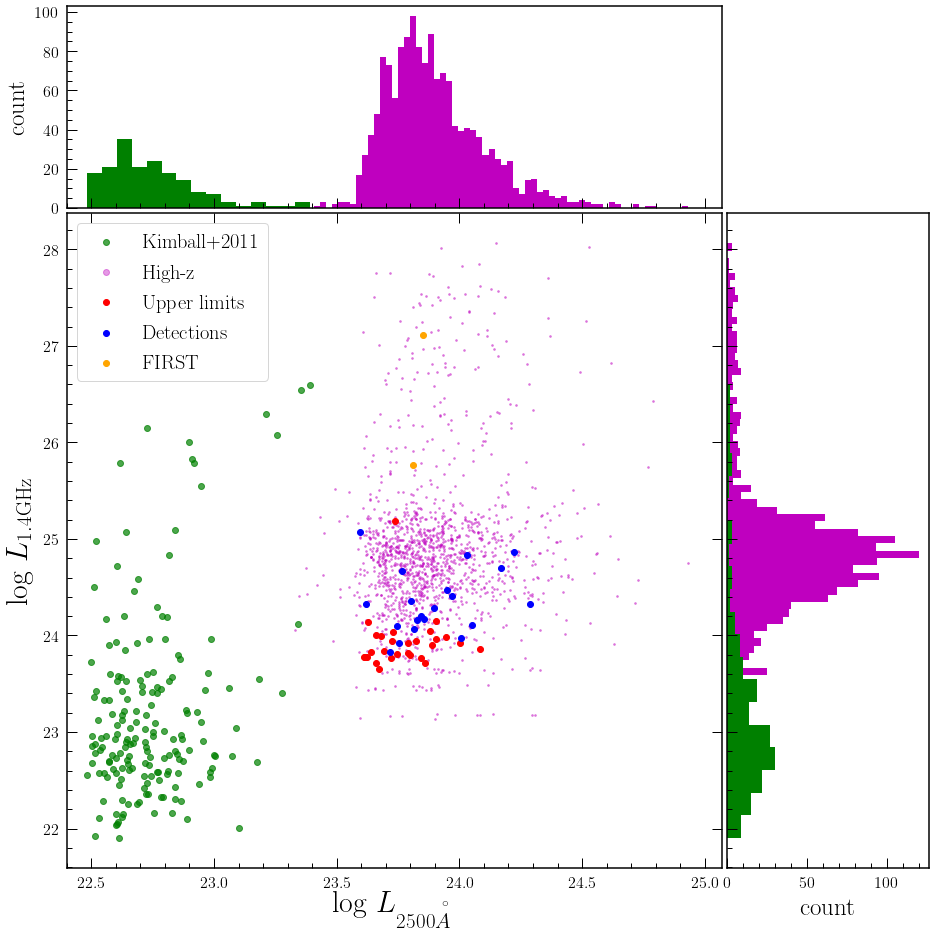

In [353]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(14, 14))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

#Draw a line representing R=1
#Req1 = np.arange(22.2, 25.5, 0.1)
#ax_scatter.plot(Req1, Req1, ":k")

#Plot Kimball/Kellermann data
ax_scatter.scatter(L2500_kell, L14_kell, color="g", alpha=0.7, label="Kimball+2011")
#Plot all positive NVSS values
ax_scatter.scatter(L2500_hiz[L14_hiz>0.], L14_hiz[L14_hiz>0.], color="m", s=3, alpha=0.4)
ax_scatter.scatter(26., 25., color="m", alpha=0.4, label="High-z")                  
#Plot GTR data
ax_scatter.scatter(logL2500[D==0], logGTR[D==0], color="red", label="Upper limits")
ax_scatter.scatter(logL2500[D==1], logGTR[D==1], color="blue", label="Detections")
ax_scatter.scatter(logL2500[D==2], logGTR[D==2], color="orange", label="FIRST")

#Plot x axis distribution
ax_histx.hist(L2500_hiz[L14_hiz>0.],bins=65,align='mid',color="m")
ax_histx.hist(L2500_kell,bins=15,align='mid',color="g")
ax_histx.set_ylabel('count', fontsize=25)

ax_histy.hist(L14_hiz[L14_hiz>0.],bins=65,orientation='horizontal',align='mid',color="m")
ax_histy.hist(L14_kell,bins=20,orientation='horizontal',align='mid',color="g")
ax_histy.set_xlabel('count', fontsize=25)

ax_scatter.set_xlabel("log $L_{2500\AA}$", fontsize=30)
ax_scatter.set_ylabel("log $L_\mathrm{1.4GHz}$", fontsize=30)
ax_scatter.legend(loc="best", prop={"size": 20.5})
ax_scatter.set_xlim(22.40, 25.07)
ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())
plt.tight_layout()
plt.savefig("PaperPlots/radioVSopt_whistos.pdf")
plt.show()

In [352]:
(L14_hiz>0.).sum()

1498

^ The NVSS objects shown are only those with $z<1.75$.  I wanted to make the green objects all of the 1313 $0.2<z<0.45$ Condon+13 QSOs, but I couldn't figure out how to do the SDSS selection... the paper only provides the list of NVSS-*detected* objects, which is only N=163, so might as well use the Kimball+2011 data (N=178) as it also contains RQ sources

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


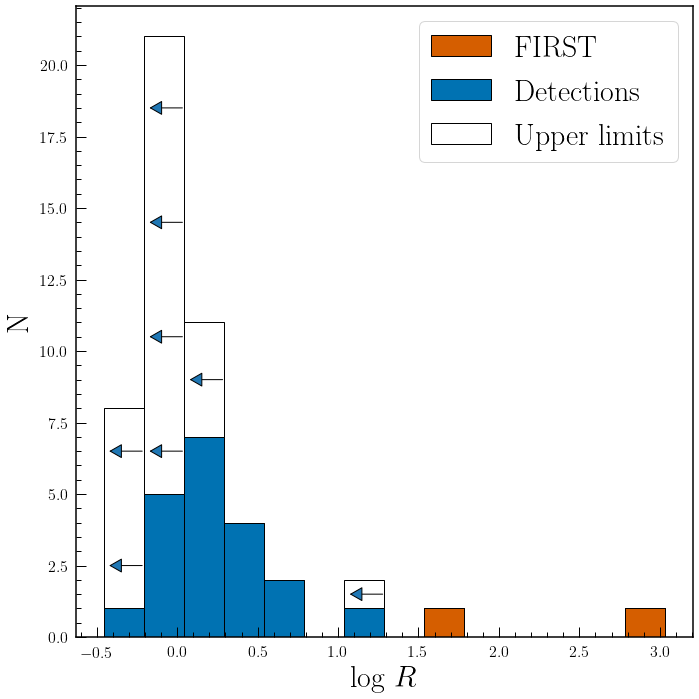

In [206]:
Rbins = np.linspace(min(logR), max(logR), 15)

fig = plt.figure(figsize=(10,10))

plt.hist([logR[D==2], logR[D==1], logR[D==0]], histtype="barstacked", bins=Rbins, 
         edgecolor="k", color=["#d55e00", "#0072b2", "w"], 
         label=["FIRST","Detections","Upper limits"])

#Upper limit symbols
plt.annotate('', xy=(-0.205, 2.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(-0.205, 6.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.annotate('', xy=(0.045, 6.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(0.045, 10.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(0.045, 14.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))
plt.annotate('', xy=(0.045, 18.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.annotate('', xy=(0.295, 9.0), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.annotate('', xy=(1.29, 1.5), xytext=(-37, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.4, head_length=0.7"))

plt.xlabel("log $R$", fontsize=30)
plt.ylabel("N", fontsize=30)
plt.legend(loc="upper right", prop={"size":30})
plt.tight_layout()
plt.savefig("PaperPlots/logR_distribution.pdf")
plt.show()

Hmm, maybe it makes more sense to make this an inset of the flux distribution figure.

/Users/trevormccaffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


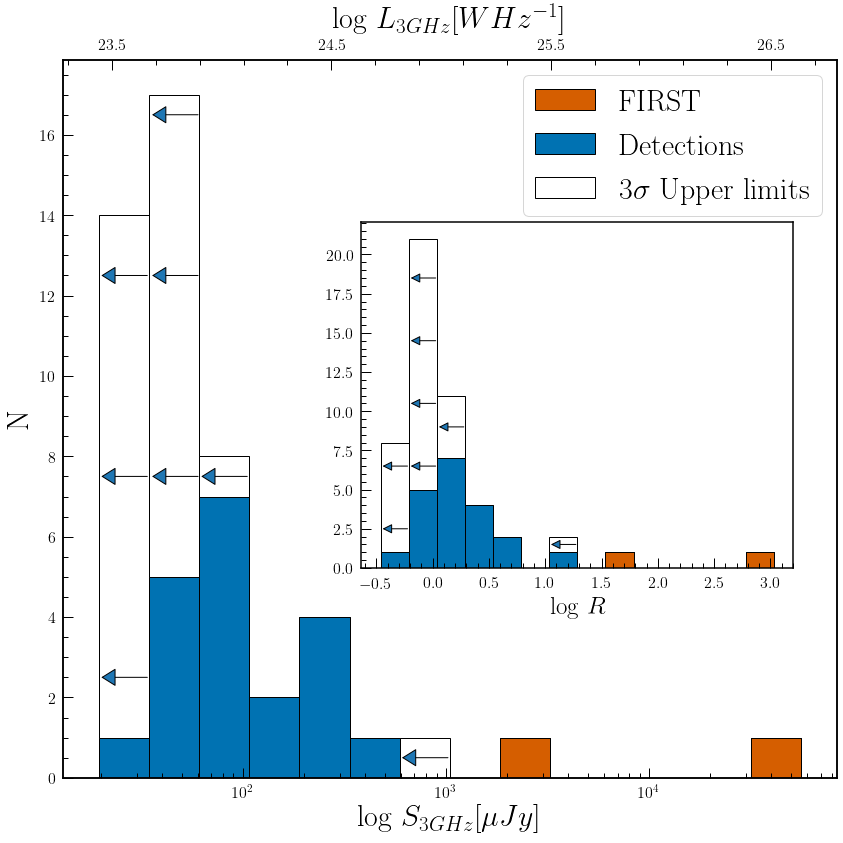

In [218]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)

Lbins = np.linspace(min(L3), max(L3), 15)
Sbins = np.logspace(np.log10(min(S3)), np.log10(max(S3)), 15)


ax1.hist([S3[D==2], S3[D==1], S3[D==0]], histtype="barstacked", color=["#d55e00", "#0072b2", "w"],
          edgecolor="k", bins=Sbins, label=["FIRST", "Detections", "3$\sigma$ Upper limits"])


#Upper limit symbols
ax1.annotate('', xy=(10**1.54, 2.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 7.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.54, 12.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**1.79, 7.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 12.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))
ax1.annotate('', xy=(10**1.79, 16.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**2.032, 7.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))


ax1.annotate('', xy=(10**3.02, 0.5), xytext=(-50, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.5, head_length=0.8"))

#ax1.set_xscale("log")
ax1.set_xlabel("log $S_{3GHz}[\\mu Jy$]", fontsize=30)
ax1.set_ylabel("N", fontsize=30)
ax1.legend(loc="best", prop={"size": 30})
ax1.set_xscale("log")

#Manually add luminosity axis
ax2 = ax1.twiny()
ax2.set_xlim(23.28,26.8)
ax2.set_xticks([23.5, 24.5, 25.5, 26.5])
ax2.set_xlabel("log $L_{3GHz} [W Hz^{-1}]$", fontsize=30)


# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.43, 0.33, 0.50, 0.40]
ax3 = fig.add_axes([left, bottom, width, height])

ax3.hist([logR[D==2], logR[D==1], logR[D==0]], histtype="barstacked", bins=Rbins, 
         edgecolor="k", color=["#d55e00", "#0072b2", "w"], 
         label=["FIRST","Detections","Upper limits"])

#Upper limit symbols
ax3.annotate('', xy=(-0.205, 2.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(-0.205, 6.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.annotate('', xy=(0.045, 6.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(0.045, 10.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(0.045, 14.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))
ax3.annotate('', xy=(0.045, 18.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.annotate('', xy=(0.295, 9.0), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.annotate('', xy=(1.29, 1.5), xytext=(-29, 0), textcoords='offset points', 
                arrowprops=dict(arrowstyle="<|-, head_width=0.25, head_length=0.5"))

ax3.set_xlabel("log $R$", fontsize=25)
#ax3.set_ylabel("N", fontsize=20)
#ax3.legend(loc="upper right")
plt.tight_layout()
plt.savefig("PaperPlots/flux_distribution_wlum_logRinset.pdf")
plt.show()